## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np

## Reading Epochs and preprocessing

In [2]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.crop(0, None)

Number of events,940
Events,Auditory left: 117Auditory right: 104Somato left: 118Somato right: 107Visual Lower left: 115Visual Lower right: 129Visual Upper left: 133Visual Upper right: 117
Time range,0.000 – 0.500 sec
Baseline,-0.100 – 0.000 sec


## Create dataset containig epoched data

In [4]:
dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
del raw, epochs, epochs_list

## Save dataset

In [5]:
dataset.save('../data/dataset.pt')

## Read dataset

In [5]:
dataset = read_epochs_dataset('../data/dataset.pt')

## Split dataset into train and test sets

In [6]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Create model, inheriting from BaseModel class.
This model has a spatial filtering layer with a choice of each n-th output and a fully connected layer for predicting

In [7]:
class TinyNet(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        pool_factor: int,
        n_outputs: int
    ):
        """
        A tiny neural network for time series classification.

        Parameters:
            n_channels (int): Number of input channels
            n_latent (int): Number of latent features
            n_times (int): Number of time steps in the input
            pool_factor (int): Pooling factor to down-sample the time series
            n_outputs (int): Number of output classes

        Attributes:
            pool_factor (int): Pooling factor to down-sample the time series
            unmixing_layer (nn.Conv1d): 1D convolutional layer for unmixing (spatial filtering) the input
            unmixing_layer_batchnorm (nn.BatchNorm1d): batch normalization layer for the unmixing layer
            features_batchnorm (nn.BatchNorm1d): batch normalization layer for the final features
            fc_layer (nn.Linear): fully connected layer for the output
        """
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        self.unmixing_layer_batchnorm = nn.BatchNorm1d(n_latent, affine=False)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        """
        Forward pass of the model

        Args:
            x (torch.Tensor): input tensor of shape (batch_size, n_channels, n_times)

        Returns:
            torch.Tensor: output tensor of shape (batch_size, n_outputs)

        """
        x = self.unmixing_layer(x)
        x = self.unmixing_layer_batchnorm(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        x = self.features_batchnorm(x)
        return self.fc_layer(x)

In [8]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

## Compile model

In [9]:
model = TinyNet(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=False)
    ]
)

## Training the model

Epoch 0:  loss_train:  0.7327   |    binary_accuracy_train:  0.5099   |    loss_val:  0.7126   |    binary_accuracy_val:  0.4939
Epoch 1:  loss_train:  0.7230   |    binary_accuracy_train:  0.5165   |    loss_val:  0.7127   |    binary_accuracy_val:  0.4972
Epoch 2:  loss_train:  0.7140   |    binary_accuracy_train:  0.5249   |    loss_val:  0.7126   |    binary_accuracy_val:  0.4972
Epoch 3:  loss_train:  0.7055   |    binary_accuracy_train:  0.5362   |    loss_val:  0.7122   |    binary_accuracy_val:  0.5019
Epoch 4:  loss_train:  0.6976   |    binary_accuracy_train:  0.5441   |    loss_val:  0.7114   |    binary_accuracy_val:  0.5102
Epoch 5:  loss_train:  0.6901   |    binary_accuracy_train:  0.5547   |    loss_val:  0.7101   |    binary_accuracy_val:  0.5122
Epoch 6:  loss_train:  0.6829   |    binary_accuracy_train:  0.5624   |    loss_val:  0.7083   |    binary_accuracy_val:  0.5206
Epoch 7:  loss_train:  0.6762   |    binary_accuracy_train:  0.5754   |    loss_val:  0.7061   | 

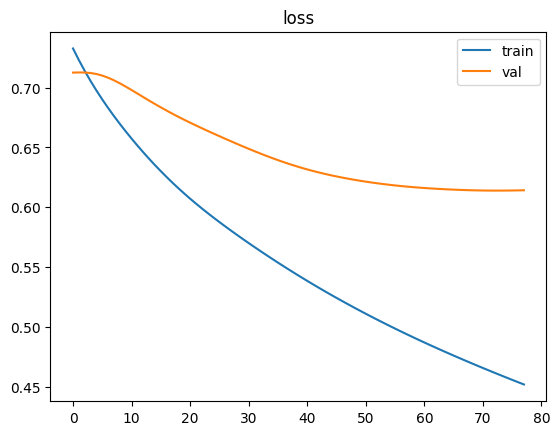

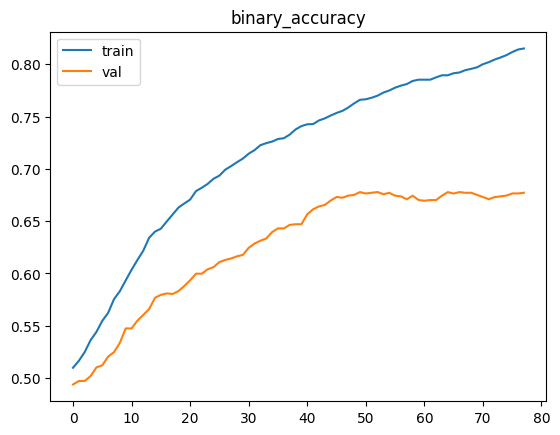

In [10]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60, update_every_n_batches=10)
plot_metrics(history)

## Evaluate the model

In [11]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.49018159779635345
train_binary_accuracy: 0.7843094359744679
loss: 0.5793365673585371
binary_accuracy: 0.6956168900836598


## Make prediction

#### Take a random sample from the test set

In [50]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 130


#### Make a prediction, print the predicted value and the actual label

In [51]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction:  1.21 | -0.31 |  0.11 | -2.77 |  0.48 |  3.39 | -0.74 | -1.76
Actual:      0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0 


## Save model weights

In [52]:
# make sure that this path exists!
model.save('../models/tinynet.pt')

## Create a new model and load weights

In [53]:
other_model = TinyNet(204, 8, 301, 10, 8)
other_model.load('../models/tinynet.pt')

## Evaluate the loaded model

In [55]:
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

# To make predictions and estimate loss, we only need to compile them. We don't need the rest of the parameters
other_model.compile(
    loss=loss,
    metrics=metric
)

train_result = other_model.evaluate(train)
result = other_model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4911928854205392
train_binary_accuracy: 0.7855550700967963
loss: 0.5828646475618536
binary_accuracy: 0.6903409145095132


## Continue training

#### Recompile the model with new parameters

In [58]:
optimizer = torch.optim.AdamW(other_model.parameters(), lr=3e-3, eps=1e-10) # Let's make another optimizer, and define it
loss = torch.nn.CrossEntropyLoss() # Let's try another loss function

other_model.compile(
    optimizer,
    loss,
    metric, # We do not change metric
    callbacks=[
        PrintingCallback(), # Callback for printing
        EarlyStopping(
            monitor='loss_val'
        ), # Callback for early stopping, but with restoring weights
        L2Reg(
            [ # to see list of layer names use list(model.state_dict().keys())
                'unmixing_layer.weight',
                'fc_layer.weight',
                'fc_layer.bias'
            ],
            [ # different lambda value for different layers
                .01,
                .005,
                .0001
            ]
        ) # l2 regularization for specified layers
    ]
)

#### Fit the model with new training parameters

Epoch 0:  loss_train:  0.5246   |    binary_accuracy_train:  0.7828   |    loss_val:  0.4643   |    binary_accuracy_val:  0.7699
Epoch 1:  loss_train:  0.3635   |    binary_accuracy_train:  0.7753   |    loss_val:  0.4525   |    binary_accuracy_val:  0.7519
Epoch 2:  loss_train:  0.2779   |    binary_accuracy_train:  0.7723   |    loss_val:  0.4481   |    binary_accuracy_val:  0.7368
Epoch 3:  loss_train:  0.2218   |    binary_accuracy_train:  0.7697   |    loss_val:  0.4466   |    binary_accuracy_val:  0.7328
Epoch 4:  loss_train:  0.1819   |    binary_accuracy_train:  0.7647   |    loss_val:  0.4490   |    binary_accuracy_val:  0.7274
Epoch 5:  loss_train:  0.1526   |    binary_accuracy_train:  0.7656   |    loss_val:  0.4531   |    binary_accuracy_val:  0.7192
Epoch 6:  loss_train:  0.1308   |    binary_accuracy_train:  0.7631   |    loss_val:  0.4558   |    binary_accuracy_val:  0.7163
Epoch 7:  loss_train:  0.1143   |    binary_accuracy_train:  0.7665   |    loss_val:  0.4573   | 

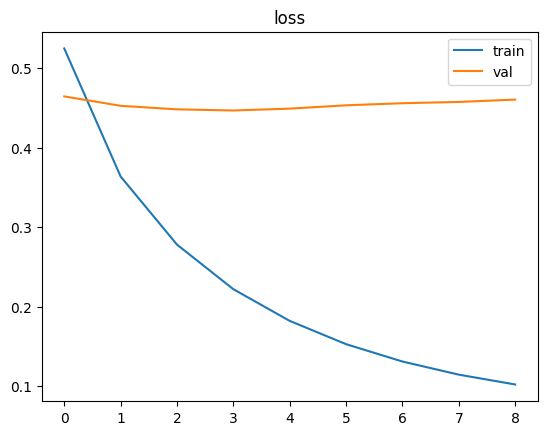

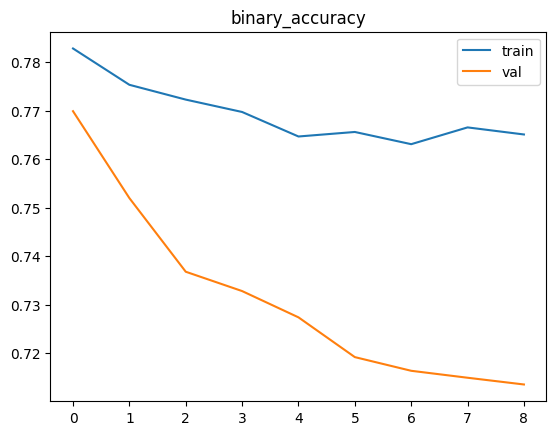

In [59]:
history = other_model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [60]:
train_result = other_model.evaluate(train)
result = other_model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.2420384558764371
train_binary_accuracy: 0.7594624107534235
loss: 0.626438623124903
binary_accuracy: 0.7065746730024164
